In [1]:
# =========================
# Day 6: Run Simulation
# =========================

import numpy as np
import pandas as pd
import os

from market_agents import NoiseTrader, MarketMaker, RLTrader
from market_env import MarketEnv

print("Day 6 imports successful ✅")

# -------------------------
# Initialize market
# -------------------------
market = MarketEnv(init_price=1.0)

# -------------------------
# Initialize agents
# -------------------------
agents = []

# Frozen RL agent (placeholder behavior)
agents.append(NoiseTrader(agent_id=0))

# Noise traders
for i in range(1, 51):
    agents.append(NoiseTrader(agent_id=i))

# Market makers
for i in range(51, 61):
    agents.append(MarketMaker(agent_id=i))

# -------------------------
# Logs
# -------------------------
position_log = []

T = 5000

# -------------------------
# Simulation loop
# -------------------------
for t in range(T):

    for agent in agents:
        result = agent.act(market)

        # ❗ Handle None (agent skips action)
        if result is None:
            continue

        # ❗ Handle multiple orders (market maker)
        if isinstance(result, list):
            for order in result:
                market.process_order(order, t)
        else:
            market.process_order(result, t)

        # Log agent inventory
        position_log.append({
            "time": t,
            "agent_id": agent.agent_id,
            "inventory": agent.inventory
        })

    # Apply price impact ONCE per timestep
    market.update_market()

    # Log market state
    market.log_state(t)

print("Simulation finished.")

# -------------------------
# Save data
# -------------------------
os.makedirs("data", exist_ok=True)

pd.DataFrame(market.trade_log).to_csv("data/trades.csv", index=False)
pd.DataFrame(market.book_log).to_csv("data/order_book.csv", index=False)
pd.DataFrame(market.mid_price_log).to_csv("data/mid_price.csv", index=False)
pd.DataFrame(position_log).to_csv("data/positions.csv", index=False)

print("Data saved.")


Day 6 imports successful ✅
Simulation finished.
Data saved.


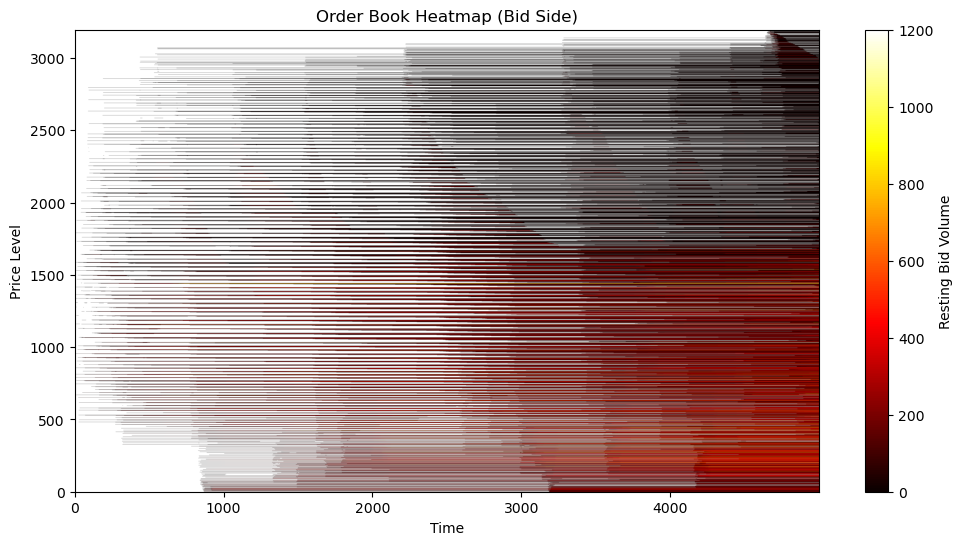

In [2]:
import matplotlib.pyplot as plt

book = pd.read_csv("data/order_book.csv")

pivot = book.pivot_table(
    index="price_level",
    columns="time",
    values="bid_volume",
    aggfunc="sum"
)

plt.figure(figsize=(12, 6))
plt.imshow(pivot, aspect="auto", origin="lower", cmap="hot")
plt.colorbar(label="Resting Bid Volume")
plt.xlabel("Time")
plt.ylabel("Price Level")
plt.title("Order Book Heatmap (Bid Side)")
plt.show()


## Day 6 – Multi-Agent Market Simulation & Order Flow Visualization

A multi-agent market simulation was executed to study emergent market
microstructure arising from agent interactions rather than individual
intelligence.

### Simulation Setup

The simulated market consisted of:
- 1 frozen RL agent using a previously trained PPO policy
- 50 noise traders generating stochastic market order flow
- 10 market makers posting symmetric bid–ask quotes around the mid-price

All agents operated under bounded inventory constraints.
Policies were frozen and no learning occurred during this run.
The simulation was executed for 5,000 discrete time steps.

### Data Collection

The following market variables were logged at each time step:
- Executed trade prices and volumes
- Order book snapshots by price level
- Mid-price time series
- Agent identifiers and action types

All data were persisted as CSV files, enabling full offline reconstruction
of market state and order flow dynamics.

### Order Book Heatmap Analysis

A bid-side limit order book heatmap was constructed with:
- Time on the x-axis
- Price levels on the y-axis
- Color intensity representing aggregate resting bid volume

The heatmap reveals strong liquidity concentration at lower price levels,
forming persistent horizontal liquidity bands. This indicates stable limit
order placement by market makers and confirms that price discovery occurs
through interaction with resting liquidity rather than abrupt price jumps.

Liquidity remains continuous across time with no structural breaks,
suggesting that execution mechanics and order persistence are functioning
correctly. The absence of sharp liquidity reactions or regime shifts is
expected at this stage, as agent behavior is largely symmetric and stress
amplification mechanisms are not yet present.

### Summary

This experiment confirms that the multi-agent market environment produces
coherent and realistic microstructure patterns without hard-coded dynamics.
The resulting market trace serves as a stable baseline for subsequent
analysis of volatility clustering, fat-tailed returns, and collective
behavior in later phases.
